In [ ]:
!pip install pandas matplotlib seaborn prophet scikit-learn

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from prophet import Prophet
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from prophet.serialize import model_to_json, model_from_json

In [46]:
DATASET_PATH = Path().cwd().parent / 'data'
START_PANDEMIC_DATE = '2020-03-11'
END_PANDEMIC_DATE = '2023-05-05'

START_PANDEMIC_DATE = pd.to_datetime(START_PANDEMIC_DATE).date()
END_PANDEMIC_DATE = pd.to_datetime(END_PANDEMIC_DATE).date()

df = pd.read_csv(DATASET_PATH / 'energy_demand_hourly_brazil.csv')

In [47]:
df.head()

,index,hourly_demand
0,2000-01-01 00:00:00,34673.9
1,2000-01-01 01:00:00,33503.0
2,2000-01-01 02:00:00,32287.6
3,2000-01-01 03:00:00,31059.4
4,2000-01-01 04:00:00,30272.7


In [48]:
df.rename(columns={'index': 'day'}, inplace=True)

df['day'] = pd.to_datetime(df['day'])
df['hour'] = df['day'].dt.hour
df['day'] = df['day'].dt.date

df.head()

,day,hourly_demand,hour
0,2000-01-01,34673.9,0
1,2000-01-01,33503.0,1
2,2000-01-01,32287.6,2
3,2000-01-01,31059.4,3
4,2000-01-01,30272.7,4


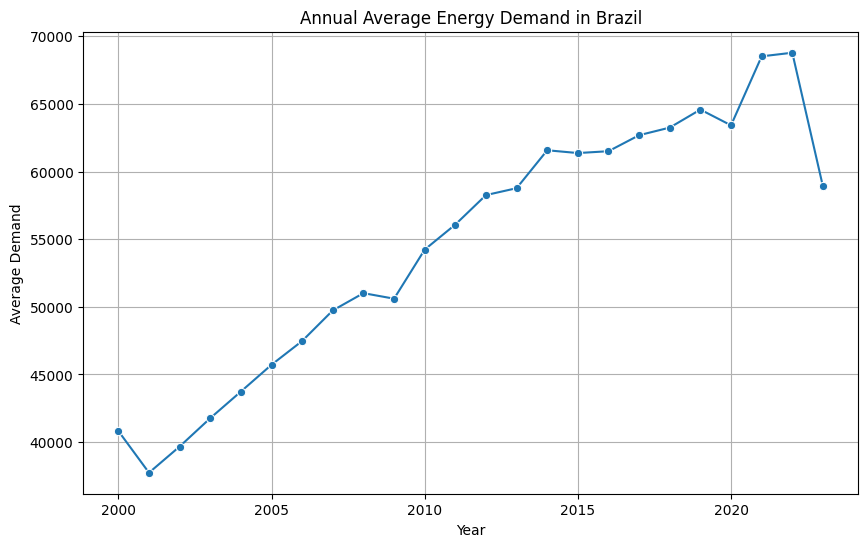

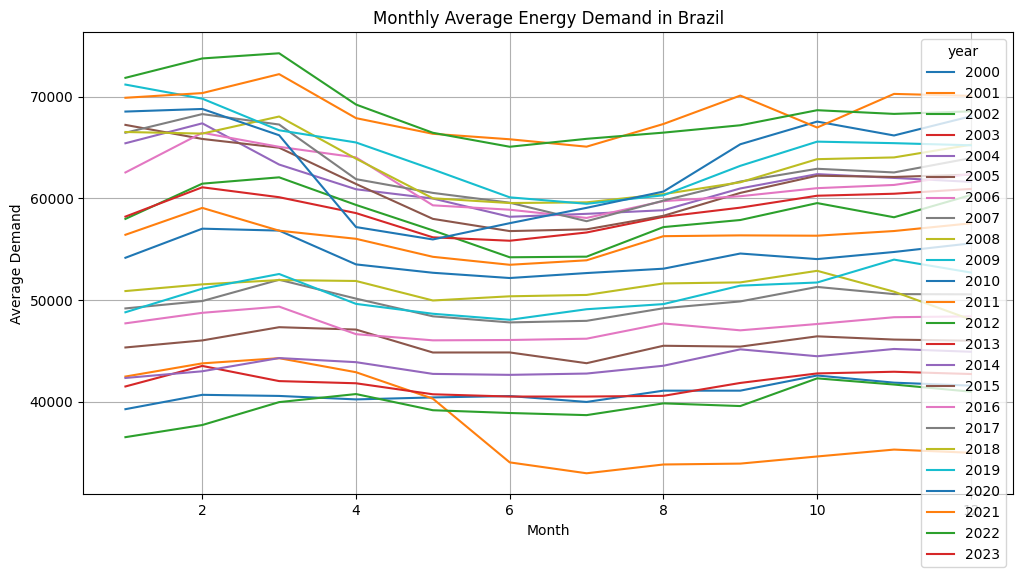

In [49]:
df['year'] = pd.DatetimeIndex(df['day']).year
df['month'] = pd.DatetimeIndex(df['day']).month

annual_demand = df.groupby('year')['hourly_demand'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.lineplot(data=annual_demand, x='year', y='hourly_demand', marker='o')
plt.title('Annual Average Energy Demand in Brazil')
plt.xlabel('Year')
plt.ylabel('Average Demand')
plt.grid()
plt.show()

monthly_demand = df.groupby(['year', 'month'])['hourly_demand'].mean().reset_index()
plt.figure(figsize=(12,6))
sns.lineplot(data=monthly_demand, x='month', y='hourly_demand', hue='year', palette='tab10')
plt.title('Monthly Average Energy Demand in Brazil')
plt.xlabel('Month')
plt.ylabel('Average Demand')
plt.grid()
plt.show()

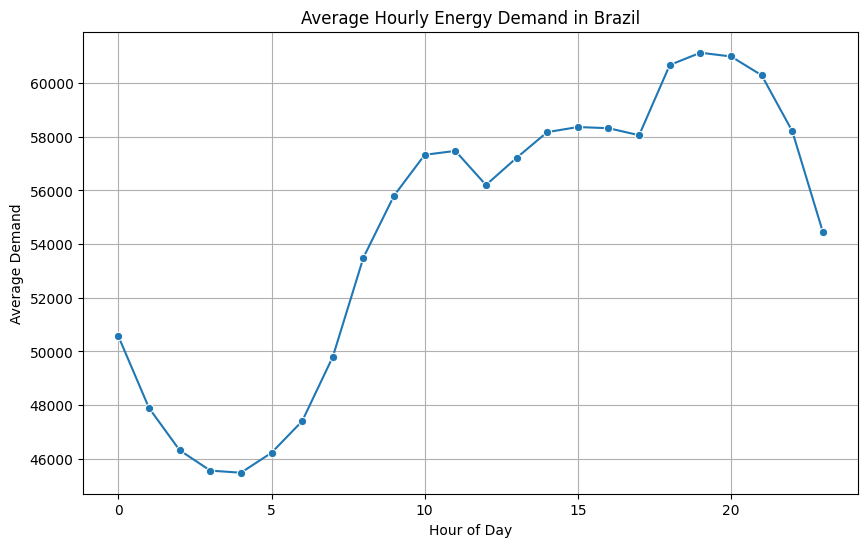

In [50]:
hourly_demand = df.groupby('hour')['hourly_demand'].mean().reset_index()
plt.figure(figsize=(10,6))
sns.lineplot(data=hourly_demand, x='hour', y='hourly_demand', marker='o')
plt.title('Average Hourly Energy Demand in Brazil')
plt.xlabel('Hour of Day')
plt.ylabel('Average Demand')
plt.grid()
plt.show()

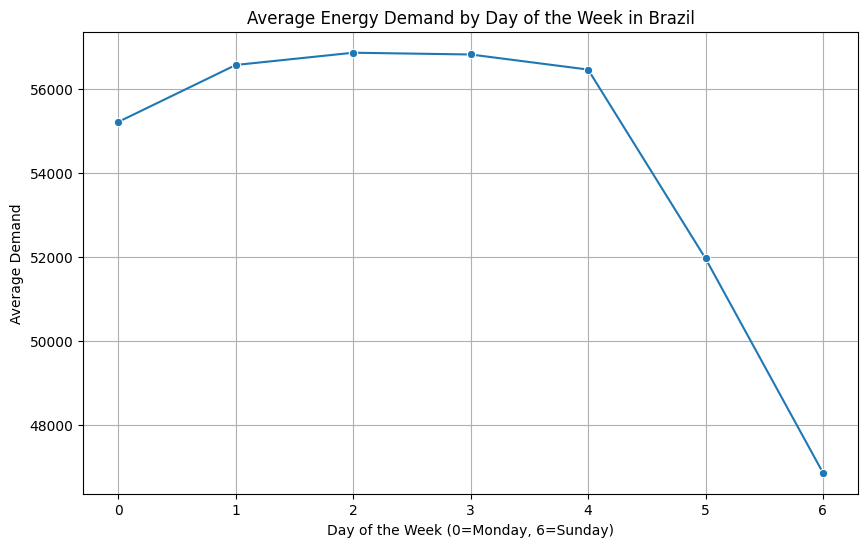

In [51]:
df['day_of_week'] = pd.DatetimeIndex(df['day']).dayofweek

weekday_demand = df.groupby('day_of_week')['hourly_demand'].mean().reset_index()

plt.figure(figsize=(10,6))
sns.lineplot(data=weekday_demand, x='day_of_week', y='hourly_demand', marker='o')
plt.title('Average Energy Demand by Day of the Week in Brazil')
plt.xlabel('Day of the Week (0=Monday, 6=Sunday)')
plt.ylabel('Average Demand')
plt.grid()
plt.show()


/tmp/ipykernel_6438/1018777525.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=monthly_demand, x='month_name', y='hourly_demand', palette='viridis')


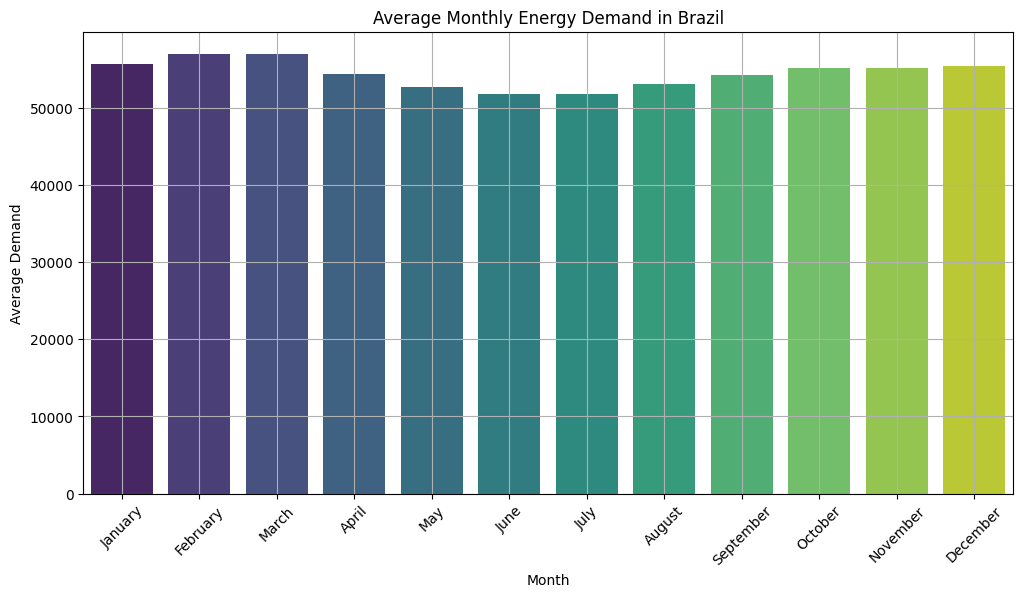

In [52]:
df['month_name'] = pd.DatetimeIndex(df['day']).month_name()

monthly_demand = df.groupby('month_name')['hourly_demand'].mean().reindex([
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
]).reset_index()

plt.figure(figsize=(12,6))
sns.barplot(data=monthly_demand, x='month_name', y='hourly_demand', palette='viridis')
plt.title('Average Monthly Energy Demand in Brazil')
plt.xlabel('Month')
plt.ylabel('Average Demand')
plt.xticks(rotation=45)
plt.grid()
plt.show()

In [53]:
df['is_pandemic'] = 0
df.loc[(df['day'] >= START_PANDEMIC_DATE) & (df['day'] < END_PANDEMIC_DATE), 'is_pandemic'] = 1

df.drop(columns=['month_name'], inplace=True)
df = df[~((df['year'] == 2023) & (df['month'] == 1) & (df['day'] == pd.to_datetime('2023-01-01').date()))]

In [54]:
df

,day,hourly_demand,hour,year,month,day_of_week,is_pandemic
0,2000-01-01,34673.900,0,2000,1,5,0
1,2000-01-01,33503.000,1,2000,1,5,0
2,2000-01-01,32287.600,2,2000,1,5,0
3,2000-01-01,31059.400,3,2000,1,5,0
4,2000-01-01,30272.700,4,2000,1,5,0
...,...,...,...,...,...,...,...
201312,2022-12-31,77128.029,19,2022,12,5,1
201313,2022-12-31,75825.344,20,2022,12,5,1
201314,2022-12-31,69894.955,21,2022,12,5,1
201315,2022-12-31,64612.355,22,2022,12,5,1


In [55]:
energy_demand_2023 = pd.read_csv(DATASET_PATH / 'CURVA_CARGA_2023.csv', sep=';')

energy_demand_2023.head(10)

,id_subsistema,nom_subsistema,din_instante,val_cargaenergiahomwmed
0,N,NORTE,2023-01-01 00:00:00,5990.553
1,NE,NORDESTE,2023-01-01 00:00:00,10455.818
2,S,SUL,2023-01-01 00:00:00,10273.827
3,SE,SUDESTE,2023-01-01 00:00:00,32183.885
4,N,NORTE,2023-01-01 01:00:00,5981.216
5,NE,NORDESTE,2023-01-01 01:00:00,10481.710
6,S,SUL,2023-01-01 01:00:00,10503.709
7,SE,SUDESTE,2023-01-01 01:00:00,32196.682
8,N,NORTE,2023-01-01 02:00:00,6031.892
9,NE,NORDESTE,2023-01-01 02:00:00,10475.740


In [56]:
energy_demand_2023['Datetime'] = pd.to_datetime(energy_demand_2023['din_instante'])
energy_demand_2023 = energy_demand_2023.groupby('Datetime')['val_cargaenergiahomwmed'].sum().reset_index()
energy_demand_2023 = energy_demand_2023[['Datetime', 'val_cargaenergiahomwmed']]

energy_demand_2023['day'] = energy_demand_2023['Datetime'].dt.date
energy_demand_2023['hour'] = energy_demand_2023['Datetime'].dt.hour
energy_demand_2023 = energy_demand_2023[['day', 'hour', 'val_cargaenergiahomwmed']]

energy_demand_2023.rename(columns={'val_cargaenergiahomwmed': 'hourly_demand'}, inplace=True)

energy_demand_2023.head()

,day,hour,hourly_demand
0,2023-01-01,0,58904.083
1,2023-01-01,1,59163.317
2,2023-01-01,2,58305.890
3,2023-01-01,3,57014.549
4,2023-01-01,4,56044.017


In [57]:
energy_demand_2023['year'] = pd.DatetimeIndex(energy_demand_2023['day']).year
energy_demand_2023['month'] = pd.DatetimeIndex(energy_demand_2023['day']).month
energy_demand_2023['day_of_week'] = pd.DatetimeIndex(energy_demand_2023['day']).dayofweek

mask = (energy_demand_2023['day'] >= START_PANDEMIC_DATE) & (energy_demand_2023['day'] < END_PANDEMIC_DATE)
energy_demand_2023['is_pandemic'] = mask.astype(int)

energy_demand_2023.head()

,day,hour,hourly_demand,year,month,day_of_week,is_pandemic
0,2023-01-01,0,58904.083,2023,1,6,1
1,2023-01-01,1,59163.317,2023,1,6,1
2,2023-01-01,2,58305.890,2023,1,6,1
3,2023-01-01,3,57014.549,2023,1,6,1
4,2023-01-01,4,56044.017,2023,1,6,1


In [58]:
df = pd.concat([df, energy_demand_2023], ignore_index=True)

df

,day,hourly_demand,hour,year,month,day_of_week,is_pandemic
0,2000-01-01,34673.900,0,2000,1,5,0
1,2000-01-01,33503.000,1,2000,1,5,0
2,2000-01-01,32287.600,2,2000,1,5,0
3,2000-01-01,31059.400,3,2000,1,5,0
4,2000-01-01,30272.700,4,2000,1,5,0
...,...,...,...,...,...,...,...
210072,2023-12-31,80074.981,19,2023,12,6,0
210073,2023-12-31,78790.270,20,2023,12,6,0
210074,2023-12-31,73543.337,21,2023,12,6,0
210075,2023-12-31,68585.202,22,2023,12,6,0


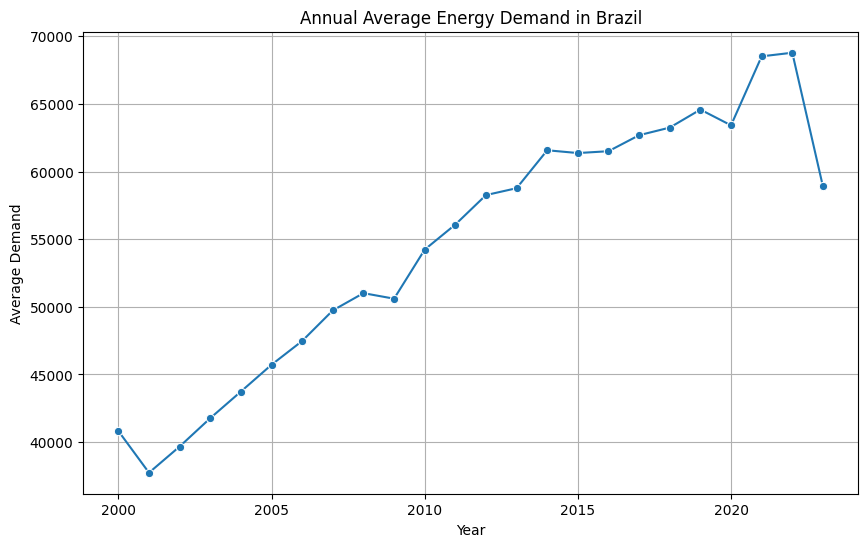

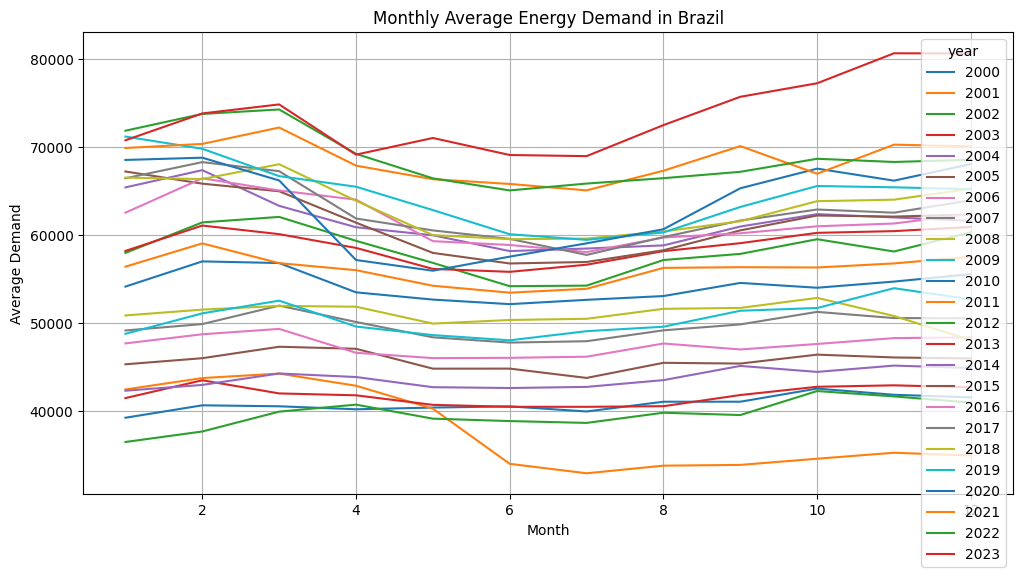

In [59]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=annual_demand, x='year', y='hourly_demand', marker='o')
plt.title('Annual Average Energy Demand in Brazil')
plt.xlabel('Year')
plt.ylabel('Average Demand')
plt.grid()
plt.show()

monthly_demand = df.groupby(['year', 'month'])['hourly_demand'].mean().reset_index()
plt.figure(figsize=(12,6))
sns.lineplot(data=monthly_demand, x='month', y='hourly_demand', hue='year', palette='tab10')
plt.title('Monthly Average Energy Demand in Brazil')
plt.xlabel('Month')
plt.ylabel('Average Demand')
plt.grid()
plt.show()

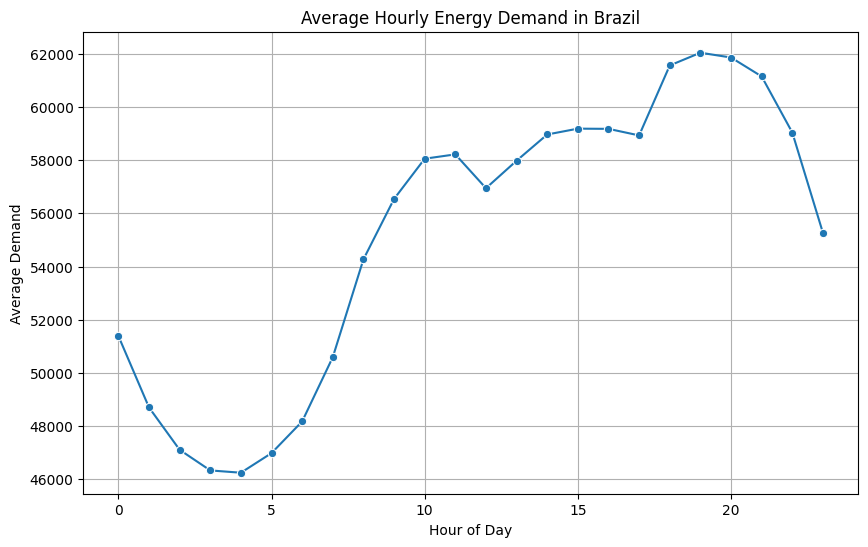

In [60]:
hourly_demand = df.groupby('hour')['hourly_demand'].mean().reset_index()
plt.figure(figsize=(10,6))
sns.lineplot(data=hourly_demand, x='hour', y='hourly_demand', marker='o')
plt.title('Average Hourly Energy Demand in Brazil')
plt.xlabel('Hour of Day')
plt.ylabel('Average Demand')
plt.grid()
plt.show()

/tmp/ipykernel_6438/1018777525.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=monthly_demand, x='month_name', y='hourly_demand', palette='viridis')


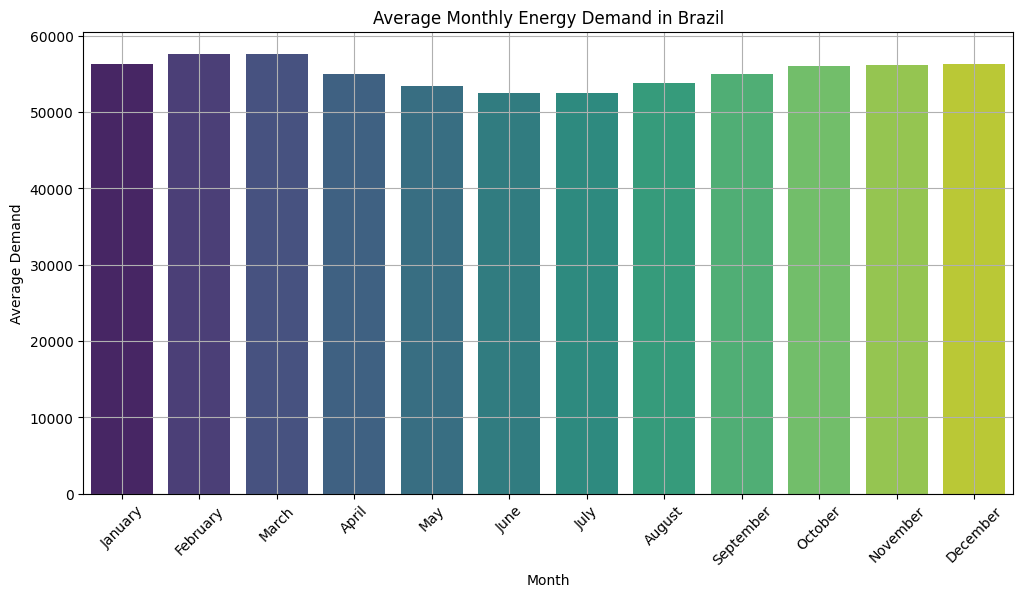

In [61]:
df['month_name'] = pd.DatetimeIndex(df['day']).month_name()

monthly_demand = df.groupby('month_name')['hourly_demand'].mean().reindex([
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
]).reset_index()

plt.figure(figsize=(12,6))
sns.barplot(data=monthly_demand, x='month_name', y='hourly_demand', palette='viridis')
plt.title('Average Monthly Energy Demand in Brazil')
plt.xlabel('Month')
plt.ylabel('Average Demand')
plt.xticks(rotation=45)
plt.grid()
plt.show()

In [62]:
forecasting_df = pd.DataFrame()
forecasting_df['ds'] = pd.to_datetime(df['day']) + pd.to_timedelta(df['hour'], unit='h')
forecasting_df['y'] = df['hourly_demand']
forecasting_df['is_pandemic'] = df['is_pandemic']

forecasting_df

,ds,y,is_pandemic
0,2000-01-01 00:00:00,34673.900,0
1,2000-01-01 01:00:00,33503.000,0
2,2000-01-01 02:00:00,32287.600,0
3,2000-01-01 03:00:00,31059.400,0
4,2000-01-01 04:00:00,30272.700,0
...,...,...,...
210072,2023-12-31 19:00:00,80074.981,0
210073,2023-12-31 20:00:00,78790.270,0
210074,2023-12-31 21:00:00,73543.337,0
210075,2023-12-31 22:00:00,68585.202,0


In [63]:
model = Prophet()
model.add_regressor('is_pandemic')

In [64]:
model.fit(forecasting_df)

06:48:44 - cmdstanpy - INFO - Chain [1] start processing
06:50:59 - cmdstanpy - INFO - Chain [1] done processing


In [65]:
df_2024 = pd.read_csv(DATASET_PATH / 'CURVA_CARGA_2024.csv', sep=';')

df_2024_to_be_predicted = pd.DataFrame()
df_2024_to_be_predicted['y'] = df_2024.groupby(['din_instante'])['val_cargaenergiahomwmed'].transform('sum')
df_2024_to_be_predicted['ds'] = pd.to_datetime(df_2024['din_instante'])

df_2024_to_be_predicted = df_2024_to_be_predicted.drop_duplicates(subset=['ds'])

df_2024_to_be_predicted['is_pandemic'] = 0
df_2024_to_be_predicted

,y,ds,is_pandemic
0,63465.030,2024-01-01 00:00:00,0
4,63745.543,2024-01-01 01:00:00,0
8,63397.932,2024-01-01 02:00:00,0
12,62454.242,2024-01-01 03:00:00,0
16,61527.395,2024-01-01 04:00:00,0
...,...,...,...
35116,84242.532,2024-12-31 19:00:00,0
35120,82461.493,2024-12-31 20:00:00,0
35124,76768.524,2024-12-31 21:00:00,0
35128,71303.920,2024-12-31 22:00:00,0


In [66]:
eval_model = pd.DataFrame()

forecast_2024 = model.predict(df_2024_to_be_predicted)
forecast_2024

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2024-01-01 00:00:00,76413.330308,61219.910188,71325.376704,76413.330308,76413.330308,-9924.643805,-9924.643805,-9924.643805,-3790.737571,...,-4193.601723,-4193.601723,-4193.601723,-1940.304511,-1940.304511,-1940.304511,0.0,0.0,0.0,66488.686503
1,2024-01-01 01:00:00,76413.633538,59401.612478,69455.009245,76413.633538,76413.633538,-12179.698608,-12179.698608,-12179.698608,-6472.741137,...,-3771.196851,-3771.196851,-3771.196851,-1935.760621,-1935.760621,-1935.760621,0.0,0.0,0.0,64233.934930
2,2024-01-01 02:00:00,76413.936768,58265.673988,68273.828122,76413.936768,76413.936768,-13270.596472,-13270.596472,-13270.596472,-7997.182395,...,-3342.274271,-3342.274271,-3342.274271,-1931.139806,-1931.139806,-1931.139806,0.0,0.0,0.0,63143.340296
3,2024-01-01 03:00:00,76414.239998,58044.609036,67909.724034,76414.239998,76414.239998,-13580.698043,-13580.698043,-13580.698043,-8744.424453,...,-2909.831390,-2909.831390,-2909.831390,-1926.442200,-1926.442200,-1926.442200,0.0,0.0,0.0,62833.541955
4,2024-01-01 04:00:00,76414.543228,57772.931772,67898.904444,76414.543228,76414.543228,-13389.829785,-13389.829785,-13389.829785,-8991.319193,...,-2476.842655,-2476.842655,-2476.842655,-1921.667937,-1921.667937,-1921.667937,0.0,0.0,0.0,63024.713443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8779,2024-12-31 19:00:00,79075.385692,79959.993941,91706.765212,77244.879978,81807.235096,6570.002351,6570.002351,6570.002351,6527.458895,...,1917.816874,1917.816874,1917.816874,-1875.273419,-1875.273419,-1875.273419,0.0,0.0,0.0,85645.388042
8780,2024-12-31 20:00:00,79075.688922,80830.093358,92294.282166,77244.668163,81807.686724,7108.582804,7108.582804,7108.582804,7102.982847,...,1875.340480,1875.340480,1875.340480,-1869.740523,-1869.740523,-1869.740523,0.0,0.0,0.0,86184.271726
8781,2024-12-31 21:00:00,79075.992152,79885.928429,91324.775315,77244.456348,81808.138352,6225.419306,6225.419306,6225.419306,6246.921913,...,1842.630004,1842.630004,1842.630004,-1864.132610,-1864.132610,-1864.132610,0.0,0.0,0.0,85301.411458
8782,2024-12-31 22:00:00,79076.295381,77066.329837,88767.022853,77244.244533,81808.589980,3591.171519,3591.171519,3591.171519,3629.536157,...,1820.085205,1820.085205,1820.085205,-1858.449844,-1858.449844,-1858.449844,0.0,0.0,0.0,82667.466900


In [67]:
eval_model['real_value_energy_demand'] = df_2024_to_be_predicted['y'].values
eval_model['predicted_energy_demand'] = forecast_2024['yhat'].values
eval_model

,real_value_energy_demand,predicted_energy_demand
0,63465.030,66488.686503
1,63745.543,64233.934930
2,63397.932,63143.340296
3,62454.242,62833.541955
4,61527.395,63024.713443
...,...,...
8779,84242.532,85645.388042
8780,82461.493,86184.271726
8781,76768.524,85301.411458
8782,71303.920,82667.466900


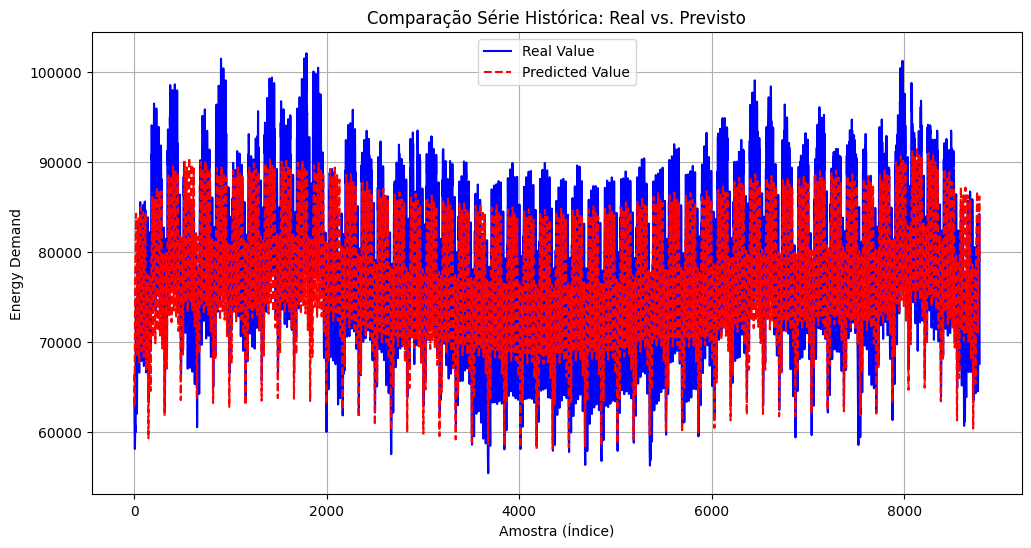

In [68]:
rmse = np.sqrt(mean_squared_error(eval_model['real_value_energy_demand'], eval_model['predicted_energy_demand']))
r2 = r2_score(eval_model['real_value_energy_demand'], eval_model['predicted_energy_demand'])

plt.figure(figsize=(12,6))
plt.plot(eval_model.index, eval_model['real_value_energy_demand'], label='Real Value', color='blue')
plt.plot(eval_model.index, eval_model['predicted_energy_demand'], label='Predicted Value', color='red', linestyle='--')
plt.title('Comparação Série Histórica: Real vs. Previsto')
plt.xlabel('Amostra (Índice)')
plt.ylabel('Energy Demand')
plt.legend()
plt.grid(True)
plt.show()

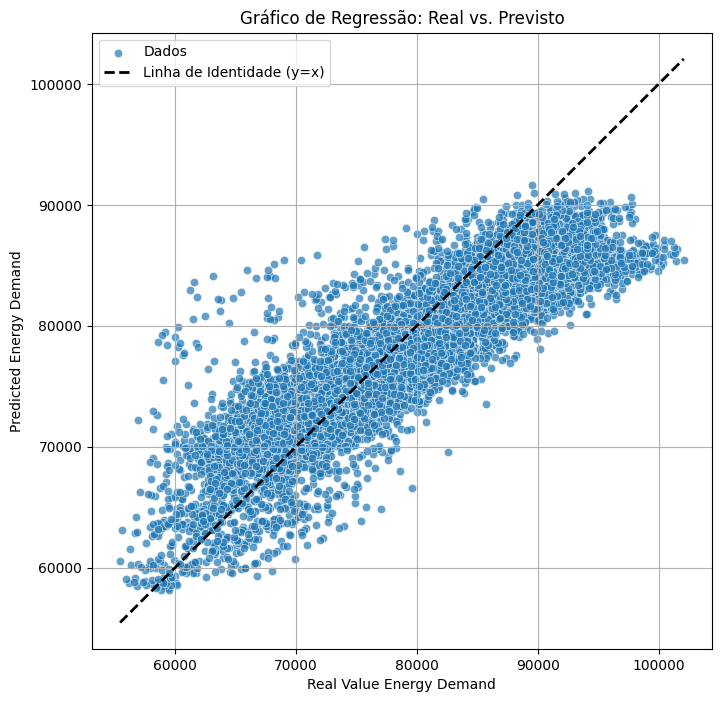

In [69]:
plt.figure(figsize=(8, 8))

sns.scatterplot(x='real_value_energy_demand', y='predicted_energy_demand', data=eval_model, alpha=0.7, label='Dados')

max_val = max(eval_model['real_value_energy_demand'].max(), eval_model['predicted_energy_demand'].max())
min_val = min(eval_model['real_value_energy_demand'].min(), eval_model['predicted_energy_demand'].min())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, label='Linha de Identidade (y=x)')

plt.title('Gráfico de Regressão: Real vs. Previsto')
plt.xlabel('Real Value Energy Demand')
plt.ylabel('Predicted Energy Demand')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()

In [74]:
with open('energy_demand_forecast_model.json', 'w') as fout:
    fout.write(model_to_json(model))

In [76]:
with open('energy_demand_forecast_model.json', 'r') as fin:
    model_loaded = model_from_json(fin.read())